In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


Training Time Series Model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.495000,0.499970,0.774400,0.775655,0.774400,0.774232
2,0.487900,0.475220,0.786200,0.790763,0.786200,0.785193
3,0.337900,0.479863,0.806200,0.806254,0.806200,0.806204



Evaluation Results: {'eval_loss': 0.4798632860183716, 'eval_accuracy': 0.8062, 'eval_precision': 0.8062541341365365, 'eval_recall': 0.8062, 'eval_f1': 0.8062035582091328, 'eval_runtime': 32.0182, 'eval_samples_per_second': 156.161, 'eval_steps_per_second': 4.903, 'epoch': 3.0}


<ipython-input-10-6e4c4e5e8be3>:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_series = torch.tensor(item["time_series"], dtype=torch.float32).unsqueeze(0).to(device)  # Float dtype



User Emotion States:
user_103: Normal
user_349: Normal
user_72: Normal
user_122: Normal
user_467: Normal
user_331: Normal
user_100: Normal
user_150: Normal
user_258: Normal
user_294: Normal
user_386: Normal
user_444: Normal
user_277: Normal
user_271: Normal
user_190: Normal
user_175: Normal
user_364: Normal
user_320: Normal
user_131: Normal
user_135: Normal
user_21: Normal
user_89: Normal
user_14: Normal
user_242: Normal
user_265: Normal
user_346: Normal
user_92: Normal
user_455: Normal
user_264: Normal
user_206: Normal
user_420: Normal
user_50: Normal
user_360: Normal
user_388: Normal
user_390: Normal
user_54: Normal
user_477: Normal
user_218: Normal
user_44: Normal
user_202: Normal
user_484: Normal
user_270: Normal
user_304: Normal
user_456: Normal
user_462: Normal
user_252: Normal
user_296: Normal
user_213: Normal
user_208: Normal
user_237: Normal
user_367: Normal
user_410: Normal
user_217: Normal
user_188: Normal
user_380: Normal
user_493: Normal
user_41: Normal
user_15: Normal
us

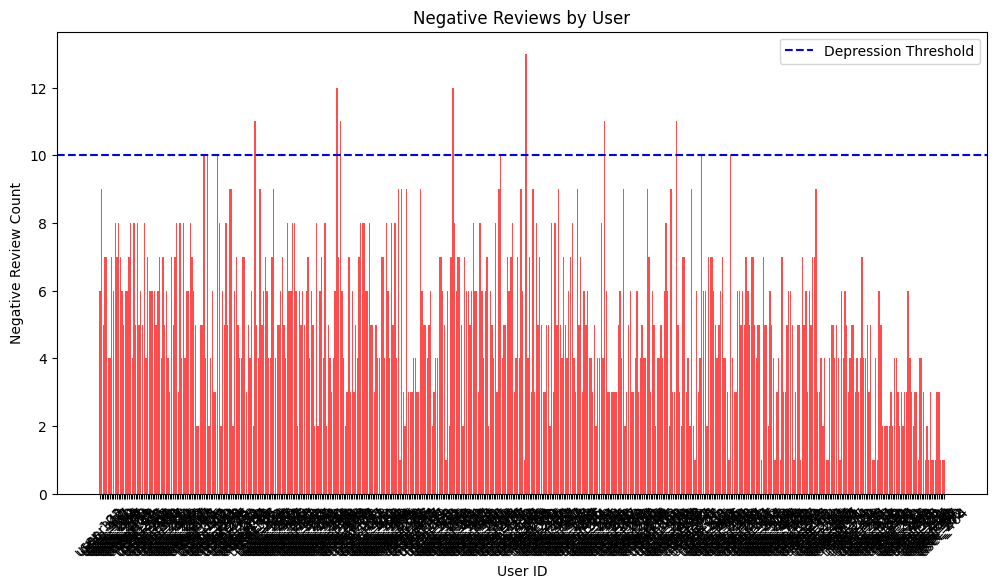

In [10]:
import torch
import torch.nn as nn
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from datetime import datetime, timedelta

# 데이터셋 로드 및 전처리
dataset = load_dataset("nsmc")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
dataset["train"] = dataset["train"].select(range(10000))
dataset["test"] = dataset["test"].select(range(5000))

# 데이터 균형화
negative_samples = [example for example in dataset["train"] if example["label"] == 1]
positive_samples = [example for example in dataset["train"] if example["label"] == 0]
balanced_samples = positive_samples + negative_samples[:len(positive_samples)]
balanced_dataset = Dataset.from_dict({key: [d[key] for d in balanced_samples] for key in balanced_samples[0].keys()})
dataset["train"] = balanced_dataset

# 시계열 데이터 생성 함수
def generate_time_series(num_samples):
    base_time = datetime(2022, 1, 1)
    time_series_data = []
    for _ in range(num_samples):
        random_offset = timedelta(minutes=np.random.randint(0, 1440))
        current_time = base_time + random_offset
        time_series_data.append([current_time.hour, current_time.minute])  # (hour, minute)
    return time_series_data

# 데이터 전처리 함수
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["document"], truncation=True, padding="max_length", max_length=128)
    time_series_data = generate_time_series(len(examples["document"]))
    tokenized_inputs["time_series"] = torch.tensor(time_series_data, dtype=torch.float32).tolist()
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "time_series", "labels"])

# Time Series 모델 정의
class BertWithTimeSeries(nn.Module):
    def __init__(self):
        super(BertWithTimeSeries, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.time_series_encoder = nn.Sequential(
            nn.Linear(2, 16),  # Time Series
            nn.ReLU(),
            nn.Linear(16, 16)
        )
        self.classifier = nn.Linear(self.bert.config.hidden_size + 16, 2)
        weights = torch.tensor([1.0, len(positive_samples) / len(negative_samples)], dtype=torch.float32).to(device)
        self.loss_fn = nn.CrossEntropyLoss(weight=weights)  # Weighted loss

    def forward(self, input_ids, attention_mask, time_series, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        time_series_features = self.time_series_encoder(time_series)
        combined_features = torch.cat((pooled_output, time_series_features), dim=1)
        logits = self.classifier(combined_features)
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

# 모델 생성 및 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
time_series_model = BertWithTimeSeries().to(device)

# 평가 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# 모델 훈련 설정
training_args = TrainingArguments(
    output_dir="./results_time_series",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer 생성
trainer = Trainer(
    model=time_series_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

# 훈련
print("\nTraining Time Series Model...")
trainer.train()

# 평가
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

# Threshold 및 사용자 수 설정
user_negative_counts = defaultdict(int)
num_users = 500
threshold = 10

# 사용자 데이터 생성
def create_user_data(dataset, num_users=num_users):
    users = [f"user_{i+1}" for i in range(num_users)]
    user_ids = np.random.choice(users, size=len(dataset["test"]), replace=True)
    dataset["test"] = dataset["test"].add_column("user_id", user_ids)
    return dataset

# 사용자별 부정적 리뷰 카운트 및 감정 상태 분석
def analyze_user_reviews(dataset, model, threshold):
    user_negative_counts = defaultdict(int)

    for item in dataset["test"]:
        user_id = item["user_id"]
        input_ids = item["input_ids"].unsqueeze(0).to(device)  # GPU로 이동
        attention_mask = item["attention_mask"].unsqueeze(0).to(device)  # GPU로 이동
        time_series = torch.tensor(item["time_series"], dtype=torch.float32).unsqueeze(0).to(device)  # Float dtype

        with torch.no_grad():
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                time_series=time_series
            )["logits"]
        prediction = torch.argmax(logits, dim=1).item()

        if prediction == 1:
            user_negative_counts[user_id] += 1

    user_emotions = {
        user_id: "Depressed" if count >= threshold else "Normal"
        for user_id, count in user_negative_counts.items()
    }

    return user_emotions, user_negative_counts

# 사용자 데이터 생성 및 분석
tokenized_dataset = create_user_data(tokenized_dataset)
user_emotions, user_negative_counts = analyze_user_reviews(tokenized_dataset, time_series_model, threshold)

# 결과 출력
print("\nUser Emotion States:")
for user_id, emotion in user_emotions.items():
    print(f"{user_id}: {emotion}")

# 사용자별 부정 리뷰 시각화
users = list(user_negative_counts.keys())
negative_counts = list(user_negative_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(users, negative_counts, color="red", alpha=0.7)
plt.axhline(y=threshold, color="blue", linestyle="--", label="Depression Threshold")
plt.xlabel("User ID")
plt.ylabel("Negative Review Count")
plt.title("Negative Reviews by User")
plt.legend()
plt.xticks(rotation=45)
plt.show()
